In [46]:
from __future__ import division, unicode_literals

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import xgboost
import re
import time 

# Чтение данных

In [47]:
train = pd.read_csv('train.csv', encoding='utf-8', 
                    lineterminator='\n')


## Доступные колонки

In [48]:
for index, field in enumerate(train.columns):
    print field

id
text
in_reply_to_user_id
user.id
user.name
user.screen_name
user.description
user.location
user.lang
user.time_zone
user.utc_offset
user.statuses_count
user.followers_count
user.friends_count
user.favourites_count
user.created_at
user.geo_enabled
user.is_translation_enabled
user.listed_count
retweet_count


Колонки являются урезанным набором полей объекта-сообщения, предоставляемого Twitter API: https://dev.twitter.com/overview/api/tweets.

## Пример записей

In [49]:
train.head()

,id,text,in_reply_to_user_id,user.id,user.name,user.screen_name,user.description,user.location,user.lang,user.time_zone,user.utc_offset,user.statuses_count,user.followers_count,user.friends_count,user.favourites_count,user.created_at,user.geo_enabled,user.is_translation_enabled,user.listed_count,retweet_count
0,629692043326062592,Me and ma fwends 🍎 http://t.co/B3YJ31hZuc,0.0,133840449,Paul C. wilson,xcaptainpaulx,Guitarist for @chunknocaptainc // Founder @off...,NaN,fr,Paris,7200.0,1606,9164,205,758,Fri Apr 16 19:33:58 +0000 2010,True,False,27,12
1,629692041362968576,@SinedioMD @AspyrMedia Try this link https://t...,7629232.0,21245956,Direct2Drive.com,Direct2Drive,D2D has an ever-expanding library of downloada...,"California, USA",en,Pacific Time (US & Canada),-25200.0,3004,7484,708,44,Wed Feb 18 21:58:04 +0000 2009,False,False,330,0
2,629692040679419904,@davidrobots @GamesRadar @David_H_Esq @CatGone...,16535125.0,63785369,Anthony John Agnello,ajohnagnello,I am the Senior Social Editor at GamesRadar+ a...,New York City,en,Eastern Time (US & Canada),-14400.0,3988,2050,491,422,Fri Aug 07 17:49:40 +0000 2009,False,False,70,0
3,629692040666812416,Already hearing scanner traffic from Heath ask...,0.0,28812126,Bethany Bruner,bethany_bruner,"Breaking News Reporter for @NewarkAdvocate, @...",NaN,en,Eastern Time (US & Canada),-14400.0,9018,919,309,79,Sat Apr 04 15:31:07 +0000 2009,True,False,38,0
4,629692038842306560,@MelJohnson6527 next year with @Chuck_Ellis #c...,181232379.0,44024059,Nolan Smith,NdotSmitty,2010 Duke National Champ! I'm Still ON A MISSI...,DMV/Durham/Louisville/ Next??,en,Quito,-18000.0,32527,85356,912,137,Tue Jun 02 01:16:08 +0000 2009,True,False,1232,1


Важно отметить, что в train.csv есть строки с описанием твитов написанных одними и теми же авторами.

Посмотреть на данные всегда полезно, прежде чем запускать какие-то алгоритмы. С помощью pandas легко отобразить матрицу парных корреляций между различными параметрами:

In [50]:
train.corr()

,id,in_reply_to_user_id,user.id,user.utc_offset,user.statuses_count,user.followers_count,user.friends_count,user.favourites_count,user.geo_enabled,user.is_translation_enabled,user.listed_count,retweet_count
id,1.000000,-0.016371,0.005814,-0.158152,-0.030182,-0.000007,0.003039,0.016018,-0.000259,-0.007774,0.001763,0.012381
in_reply_to_user_id,-0.016371,1.000000,0.045969,0.074553,0.145585,0.023351,0.034055,0.052228,-0.059220,-0.009453,-0.027885,-0.014200
user.id,0.005814,0.045969,1.000000,0.079626,-0.127492,-0.069931,-0.045684,-0.044838,-0.126254,-0.030064,-0.080045,-0.004318
user.utc_offset,-0.158152,0.074553,0.079626,1.000000,0.080790,0.020097,-0.030437,-0.043471,0.025723,-0.000572,-0.059346,-0.004953
user.statuses_count,-0.030182,0.145585,-0.127492,0.080790,1.000000,0.052894,0.127003,0.024958,0.077813,0.040412,0.054768,-0.009976
user.followers_count,-0.000007,0.023351,-0.069931,0.020097,0.052894,1.000000,0.136822,0.022280,-0.035867,0.310828,0.845898,0.577299
user.friends_count,0.003039,0.034055,-0.045684,-0.030437,0.127003,0.136822,1.000000,0.179443,0.008857,0.025236,0.099393,0.057979
user.favourites_count,0.016018,0.052228,-0.044838,-0.043471,0.024958,0.022280,0.179443,1.000000,0.080932,0.018860,0.020612,0.000729
user.geo_enabled,-0.000259,-0.059220,-0.126254,0.025723,0.077813,-0.035867,0.008857,0.080932,1.000000,-0.010995,-0.026231,-0.011232
user.is_translation_enabled,-0.007774,-0.009453,-0.030064,-0.000572,0.040412,0.310828,0.025236,0.018860,-0.010995,1.000000,0.272556,0.089645


Из матрицы парных корреляций видно,что есть относительно сильная коореляция между числом подписчиков и числом ретвитов, а также между statuses_count и  числом ретвитов.

# Вычисление признаков

Согласно исследованию из Zarrella, D. Science of Retweets твиты содержащиее ссылки ретвитятся значительно чаще. Имеет смысл воспользоваться этим наблюдением, и создать признак олицетсовряющий число ссылок в твите. 

In [51]:
buf = []
time_buf = []
for index, row in train.iterrows():
    # links counting
    urls_matches = re.findall("(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?", row['text'])
    urls_matches_count = len(urls_matches)          
    buf.append(urls_matches_count)
    
    # time converting 
    ts = time.strftime('%s', time.strptime(row['user.created_at'],'%a %b %d %H:%M:%S +0000 %Y'))
    time_buf.append(ts)    
    
               
train['urls_count'] = pd.Series(np.array(buf), index=train.index)
train['user.created_at'] = pd.Series(np.array(time_buf), index=train.index)
train.corr()

,id,in_reply_to_user_id,user.id,user.utc_offset,user.statuses_count,user.followers_count,user.friends_count,user.favourites_count,user.geo_enabled,user.is_translation_enabled,user.listed_count,retweet_count,urls_count
id,1.000000,-0.016371,0.005814,-0.158152,-0.030182,-0.000007,0.003039,0.016018,-0.000259,-0.007774,0.001763,0.012381,0.003073
in_reply_to_user_id,-0.016371,1.000000,0.045969,0.074553,0.145585,0.023351,0.034055,0.052228,-0.059220,-0.009453,-0.027885,-0.014200,-0.273000
user.id,0.005814,0.045969,1.000000,0.079626,-0.127492,-0.069931,-0.045684,-0.044838,-0.126254,-0.030064,-0.080045,-0.004318,-0.023376
user.utc_offset,-0.158152,0.074553,0.079626,1.000000,0.080790,0.020097,-0.030437,-0.043471,0.025723,-0.000572,-0.059346,-0.004953,-0.043842
user.statuses_count,-0.030182,0.145585,-0.127492,0.080790,1.000000,0.052894,0.127003,0.024958,0.077813,0.040412,0.054768,-0.009976,-0.157333
user.followers_count,-0.000007,0.023351,-0.069931,0.020097,0.052894,1.000000,0.136822,0.022280,-0.035867,0.310828,0.845898,0.577299,0.064449
user.friends_count,0.003039,0.034055,-0.045684,-0.030437,0.127003,0.136822,1.000000,0.179443,0.008857,0.025236,0.099393,0.057979,-0.043654
user.favourites_count,0.016018,0.052228,-0.044838,-0.043471,0.024958,0.022280,0.179443,1.000000,0.080932,0.018860,0.020612,0.000729,-0.083600
user.geo_enabled,-0.000259,-0.059220,-0.126254,0.025723,0.077813,-0.035867,0.008857,0.080932,1.000000,-0.010995,-0.026231,-0.011232,-0.009567
user.is_translation_enabled,-0.007774,-0.009453,-0.030064,-0.000572,0.040412,0.310828,0.025236,0.018860,-0.010995,1.000000,0.272556,0.089645,0.037403


In [52]:
train.head()

,id,text,in_reply_to_user_id,user.id,user.name,user.screen_name,user.description,user.location,user.lang,user.time_zone,...,user.statuses_count,user.followers_count,user.friends_count,user.favourites_count,user.created_at,user.geo_enabled,user.is_translation_enabled,user.listed_count,retweet_count,urls_count
0,629692043326062592,Me and ma fwends 🍎 http://t.co/B3YJ31hZuc,0.0,133840449,Paul C. wilson,xcaptainpaulx,Guitarist for @chunknocaptainc // Founder @off...,NaN,fr,Paris,...,1606,9164,205,758,1271435638,True,False,27,12,1
1,629692041362968576,@SinedioMD @AspyrMedia Try this link https://t...,7629232.0,21245956,Direct2Drive.com,Direct2Drive,D2D has an ever-expanding library of downloada...,"California, USA",en,Pacific Time (US & Canada),...,3004,7484,708,44,1234987084,False,False,330,0,1
2,629692040679419904,@davidrobots @GamesRadar @David_H_Esq @CatGone...,16535125.0,63785369,Anthony John Agnello,ajohnagnello,I am the Senior Social Editor at GamesRadar+ a...,New York City,en,Eastern Time (US & Canada),...,3988,2050,491,422,1249656580,False,False,70,0,0
3,629692040666812416,Already hearing scanner traffic from Heath ask...,0.0,28812126,Bethany Bruner,bethany_bruner,"Breaking News Reporter for @NewarkAdvocate, @...",NaN,en,Eastern Time (US & Canada),...,9018,919,309,79,1238848267,True,False,38,0,0
4,629692038842306560,@MelJohnson6527 next year with @Chuck_Ellis #c...,181232379.0,44024059,Nolan Smith,NdotSmitty,2010 Duke National Champ! I'm Still ON A MISSI...,DMV/Durham/Louisville/ Next??,en,Quito,...,32527,85356,912,137,1243894568,True,False,1232,1,0


К сожалению явной корреляции между числом ссылок и колличеством ретвитов не наблюдается, тем не менее считаю разумным отсавить этот признак. Возможно он позволит получить хорошую разделимость совместно с другими признаками.

Так же в число признаков добавим вышеотмеченные число подпиcчиков и listed count.

Так же запомним индексы уникальных идентификаторов пользователей.Нам они позжепонадобятся.

In [53]:
def df2features(df):
    return np.array([
        df['user.id'],
        df['user.followers_count'],
        df['urls_count'],
        df['user.created_at'],           
    ]).transpose()

train_X = df2features(train)


user_id_column = np.array([
        train['user.id']
    ]).transpose()

n_samples, n_features = train_X.shape



Вычисляем значения целевого признака в обучающей выборке.

In [54]:
train_y = train['retweet_count'] > 20


# Построение моделей и оценка их качества 




Кросс-валидация

Поскольку мы хотим построить модель с несколько большей степенью обобщения, чем элементарное заучивание уникальных идентификаторов авторов, то нам нужно позаботиться от том, чтобы в валидационной выборке ОТСУТСТВОВАЛИ строки с описанием твитов написанных авторами ИМЕЮЩИМИСЯ в тренировочной выборке. Как мы этого можем добиться? Достаточно сделать разбиение не на множестве уникальных идентификаторов твитов, а на множестве уникальных идентификаторов пользователей. Таким образом в валидациооной выборке не будут встречаться твиты написанные авторами уже имеющимися в тренировочном множестве.

In [55]:
clf = DecisionTreeClassifier(min_samples_leaf=50)
scores = cross_val_score(clf, train_X,  y=train_y, groups=user_id_column, cv=6, scoring='roc_auc')
print("Accuracy_of_tree: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))   

clf2 = RandomForestClassifier(n_estimators=100, min_samples_leaf=15)
scores = cross_val_score(clf2, train_X,  y=train_y, groups=user_id_column, cv=6, scoring='roc_auc')
print("Accuracy_of_random_forest: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))  

clf3 = xgboost.XGBClassifier()
scores = cross_val_score(clf2, train_X,  y=train_y, groups=user_id_column, cv=6, scoring='roc_auc')
print("Accuracy_of_xgboost: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))  

Accuracy_of_tree: 0.86 (+/- 0.01)
Accuracy_of_random_forest: 0.89 (+/- 0.01)
Accuracy_of_xgboost: 0.89 (+/- 0.02)


Число деревьев для случайного леса выбрано "на глаз" с запасом (при этом числе уже имеет место насыщение и более увеличивать колличество деревьев нет смысла).

Как видим, точность предсказания невысокая. Это связано с тем что выбранные признаки не являются слишком ифнормативными и алгоритму сложно по ним производить разбиения с низким числом ошибок первого и второго рода.

Визуализируем рабочие характеристики приёмника на каждом из тестовых множеств для каждого классификатора.

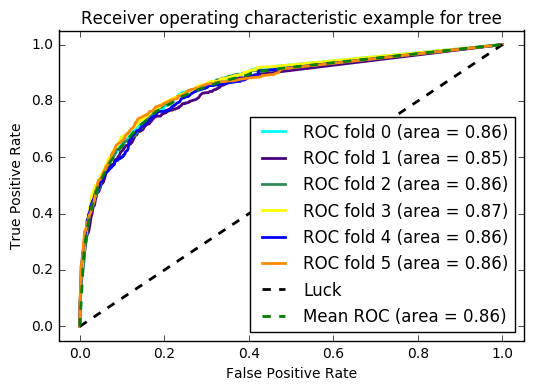

In [58]:
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = DecisionTreeClassifier(min_samples_leaf=50)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2


i = 0
for (train, test), color in zip(cv.split(user_id_column, train_y), colors):
    probas_ = classifier.fit(train_X[train], train_y[train]).predict_proba(train_X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(train_y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(train_X, train_y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example for tree')
plt.legend(loc="lower right")
plt.show()

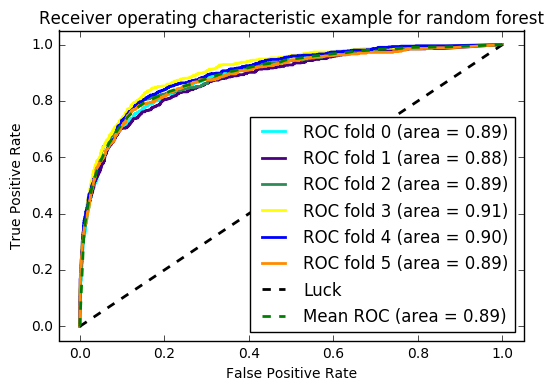

In [59]:
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2


i = 0
for (train, test), color in zip(cv.split(user_id_column, train_y), colors):
    probas_ = classifier.fit(train_X[train], train_y[train]).predict_proba(train_X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(train_y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(train_X, train_y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example for random forest')
plt.legend(loc="lower right")
plt.show()

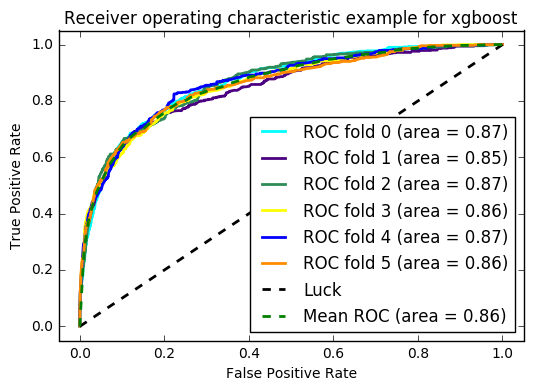

In [60]:
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = xgboost.XGBClassifier()

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2


i = 0
for (train, test), color in zip(cv.split(user_id_column, train_y), colors):
    probas_ = classifier.fit(train_X[train], train_y[train]).predict_proba(train_X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(train_y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(train_X, train_y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example for xgboost')
plt.legend(loc="lower right")
plt.show()

Обучим наилучшую модель на всём обуающем множестве

In [63]:
best_clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=15)
best_clf.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Построение и запись прогноза

Читаем демо-файл с прогнозом

In [64]:
test = pd.read_csv('test.csv', encoding='utf-8', 
                    dialect='excel', lineterminator='\n')
test.head()

,id,text,in_reply_to_user_id,user.id,user.name,user.screen_name,user.description,user.location,user.lang,user.time_zone,user.utc_offset,user.statuses_count,user.followers_count,user.friends_count,user.favourites_count,user.created_at,user.geo_enabled,user.is_translation_enabled,user.listed_count
0,629692042952765440,@clairelifsey Not with our Social team. How ca...,2.776546e+08,85741735,Amazon Help,AmazonHelp,We answer Amazon support questions 7 days a we...,NaN,en,Quito,-18000.0,314701,29337,40,18,Wed Oct 28 04:17:54 +0000 2009,False,False,236
1,629692042717855745,@Situationallday You can also contact our Live...,3.038444e+08,1567914936,Vodafone UK Help,VodafoneUKhelp,"The official home of Vodafone UK’s help team, ...",NaN,en-gb,London,3600.0,353703,25051,1131,316,Thu Jul 04 10:58:51 +0000 2013,False,False,90
2,629692039974813696,@careydavid00 Hello David! Please send us your...,3.308503e+09,62643312,ATTCares,ATTCares,Want help from a real person? Tweet your issue...,NaN,en,Central Time (US & Canada),-18000.0,879585,124830,20510,1686,Mon Aug 03 22:42:55 +0000 2009,False,False,918
3,629692038242566145,"Barry Dodson, former Rotherham mayor, cleared ...",0.000000e+00,87818409,The Guardian,guardian,"Top stories, special features, live blogs and ...",London,en,London,3600.0,169101,4017548,1094,133,Thu Nov 05 23:49:19 +0000 2009,False,True,40404
4,629692036879413248,@LemonDrizzleHM @ITV The One and Only Cilla if...,5.665833e+08,26765941,ITV Player,itvplayer,Watch live TV or catch up on all your favourit...,UK,en,London,3600.0,9413,20282,1511,1470,Thu Mar 26 14:53:59 +0000 2009,False,False,121


In [69]:
buf = []
time_buf = []
for index, row in test.iterrows():
    # links counting
    urls_matches = re.findall("(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?", row['text'])
    urls_matches_count = len(urls_matches)          
    buf.append(urls_matches_count)
    
    # time converting 
    ts = time.strftime('%s', time.strptime(row['user.created_at'],'%a %b %d %H:%M:%S +0000 %Y'))
    time_buf.append(ts)  
               
test['urls_count'] = pd.Series(np.array(buf), index=test.index)
test['user.created_at'] = pd.Series(np.array(time_buf), index=test.index)

def df2features(df):
    return np.array([
        df['user.id'],
        df['user.followers_count'],
        df['urls_count'],
        df['user.created_at'],
    ]).transpose()



test_X = df2features(test)


  
  
             


Читаем демо-файл с прогнозом

In [70]:
prediction = pd.read_csv('sample_prediction.csv')

prediction.head()

,id,probability
0,629692042952765440,0.765988
1,629692042717855745,0.160099
2,629692039974813696,0.825652
3,629692038242566145,0.495118
4,629692036879413248,0.656044


Строим новый прогноз и обновляем вероятности того, что ретвитов больше 20.

In [71]:
proba = best_clf.predict_proba(test_X)

prediction['probability'] = proba[:,1]

Записываем полученный результат в файл **prediction.csv**.

In [72]:
prediction.to_csv('prediction.csv', index=False)

In [73]:
prediction.head()

,id,probability
0,629692042952765440,0.034935
1,629692042717855745,0.110228
2,629692039974813696,0.035665
3,629692038242566145,0.796451
4,629692036879413248,0.029518


# Итоги

Недостатки проделланной работы:

    1) Составлено малое колличество признаков и произведена лишь их простейшая оценка информативности (за счет корреляции с целевой переменной каждого признака по отдельности). В идеале нужно было составить большее колличество признаков и производить их отбор в процессе кросс-валидации на ОБУЧАЮЩЕМ множестве.
    2) Произведенна оценка качества модели,но не произведен подбор оптимальных параметров для моделей. Например,не произведен прунинг решающего дерева в процессе кросс-валидации несмотря на то. Не произведен отбор оптимальных параметров для градиентного бустинга.
    3) Не произведен бутстрэпинг тренировочной выборки не смотря на то,что она недостаточного размера, как следствие на такой выборке проще переобучиться